In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from typing import List, Dict, Any, Callable

DATA_DIR = "../data"

## 1. Data Loading

In [2]:
data = pd.read_csv(f"{DATA_DIR}/medium.csv")
data

,Title,Text
0,A Beginner’s Guide to Word Embedding with Gens...,1. Introduction of Word2vec\n\nWord2vec is one...
1,Hands-on Graph Neural Networks with PyTorch & ...,"In my last article, I introduced the concept o..."
2,How to Use ggplot2 in Python,Introduction\n\nThanks to its strict implement...
3,Databricks: How to Save Data Frames as CSV Fil...,Photo credit to Mika Baumeister from Unsplash\...
4,A Step-by-Step Implementation of Gradient Desc...,A Step-by-Step Implementation of Gradient Desc...
...,...,...
1386,Brain: A Mystery,“The most beautiful experience we can have is ...
1387,Machine Learning: Lincoln Was Ahead of His Time,Photo by Jp Valery on Unsplash\n\nIn the 45th ...
1388,AI and Us — an Opera Experience. In my previou...,EKHO COLLECTIVE: OPERA BEYOND SERIES\n\nIn my ...
1389,Digital Skills as a Service (DSaaS),Have you ever thought about what will be in th...


In [3]:
paragraphs = data["Text"].str.split("\n\n").explode()
pars_df = paragraphs.reset_index().rename(columns={"index": "article_idx"})
pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec
1,0,Word2vec is one of the most popular technique ...
2,0,There are two main training algorithms for wor...
3,0,2. Gensim Python Library Introduction
4,0,Gensim is an open source python library for na...
...,...,...
50219,1390,PII refers to information that can be used to ...
50220,1390,"For anyone that works with data about people, ..."
50221,1390,Conclusion: We’re Still Working On It
50222,1390,It is perhaps unsatisfying to know that no per...


## 2. Data Preprocessing

In [4]:
def groups_to_dict(groups: List[List[int]]) -> Dict[int, int]:
    """Creates mapping from element to index of group it belongs to

    Args:
        groups (List[List[int]]): list of groups of elements

    Returns:
        Dict[int, int]: dictionary representing mapping element -> group_idx
    """
    elem_to_group = {}
    for i, group in enumerate(groups):
        for elem in group:
            elem_to_group[elem] = i
    return elem_to_group


def group_df_by_inds(df: pd.DataFrame, groups: List[List[int]], agg_mapping: Dict[str, Callable]) -> pd.DataFrame:
    """Aggregates rows of dataframe within specified groups using functions specified in 'agg_mapping'

    Args:
        df (pd.DataFrame): dataframe, rows of which should be aggregated
        groups (List[List[int]]): list of groups of indices from 'df' 
        agg_mapping (Dict[str, Callable]): dictionary mapping (column_name -> agg_function)

    Returns:
        pd.DataFrame: result of aggregating within groups
    """
    idx_to_group = groups_to_dict(groups)

    grouped = df.groupby(
        pd.Series(df.index).apply(idx_to_group.__getitem__)
    ).agg(agg_mapping).reset_index(drop=True)
    return grouped

### Dealing with code 
- Classifying lines containing code through a set of regex patterns
- Grouping consecutive lines of code into a single paragraph

**Note**: of course, these regex patterns are just a heuristic and work only for Python (will work poorly for other languages and command line commands). Ideally, we would train some classifier to classify whether a given strip of text is code or not. It could be a `NaiveBayes`, `SVM`, `LSTM` or any other suitable one. However here, due to lack of labeled data and time contraints, we decided to move forward with regex patterns 

In [5]:
patterns = {
    "meth_call": r"\w+\.\w+\(",
    "class_def": r"class \w+:",
    "func_def": r"def \w+\(",
    "comment": r"#+ \w+",
    "loop": r"^[(for)(while)] .+:$",
    "assign": r"\w+ ?[+-/*]?= ?.+",
    "alpha_num": r"\w"
}

par_feats_df = pars_df.copy()
for patt_name, patt in patterns.items():
    par_feats_df[patt_name] = par_feats_df["Text"].str.count(patt)

code_suspects = par_feats_df.loc[(par_feats_df.loc[:, "meth_call":"assign"].sum(axis=1) > 0) | (par_feats_df["alpha_num"] == 0)]
code_suspects

,article_idx,Text,meth_call,class_def,func_def,comment,loop,assign,alpha_num
18,0,>>> df = pd.read_csv('data.csv'),1,0,0,0,0,1,19
19,0,>>> df.head(),1,0,0,0,0,0,6
27,0,# Select features from original dataset to for...,0,0,0,1,0,0,52
28,0,">>> df1 = df[['Engine Fuel Type','Transmission...",0,0,0,1,0,1,139
29,0,">>> df2 = df1.apply(lambda x: ','.join(x.astyp...",2,0,0,1,0,1,64
...,...,...,...,...,...,...,...,...,...
50107,1384,"df = CSV.read(""Summary of Weather.csv"")",1,0,0,0,0,1,28
50111,1384,df.Date = [i = DateTime(i) for i in df.Date],0,0,0,0,0,1,28
50112,1384,df.Date = [i = year(i) for i in df.Date],0,0,0,0,0,1,24
50114,1384,"df = DataFrame(:Date => df.Date,:Precipitation...",0,0,0,0,0,1,56


In [7]:
is_code_mask = np.zeros(len(pars_df), dtype=np.bool_)
is_code_mask[code_suspects.index] = True

temp_df = pars_df.copy()
temp_df["is_code"] = is_code_mask
groups = []
for art_idx in temp_df["article_idx"].unique():
    article_df: pd.DataFrame = temp_df.loc[temp_df["article_idx"] == art_idx]
    for val, group in itertools.groupby(article_df.index, key=article_df["is_code"].__getitem__):
        if val:
            groups.append(list(group))
        else:
            groups.extend([[elem] for elem in group])

reduced_pars_df = group_df_by_inds(
    pars_df,
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": "\n".join
    }
)
reduced_pars_df

,article_idx,Text
0,0,1. Introduction of Word2vec
1,0,Word2vec is one of the most popular technique ...
2,0,There are two main training algorithms for wor...
3,0,2. Gensim Python Library Introduction
4,0,Gensim is an open source python library for na...
...,...,...
45451,1390,PII refers to information that can be used to ...
45452,1390,"For anyone that works with data about people, ..."
45453,1390,Conclusion: We’re Still Working On It
45454,1390,It is perhaps unsatisfying to know that no per...


### Semantic Chunking

In [9]:
def get_cos_sims(embeds: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(embeds, axis=1)
    return (embeds[1:] * embeds[:-1]).sum(axis=1) / norms[1:] / norms[:-1]

In [10]:
## OPTION 1: GENERATE EMBEDDINGS AND SAVE THEM
# from langchain.embeddings.huggingface import HuggingFaceEmbeddings
# embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
# par_embeds = np.array(embeddings.embed_documents(reduced_pars_df["Text"].tolist()))
# np.save(f"{DATA_DIR}/par_embeds.npy", par_embeds)

## OPTION 2: LOAD PREGENERATED EMBEDDINGS
par_embeds = np.load(f"{DATA_DIR}/par_embeds.npy")

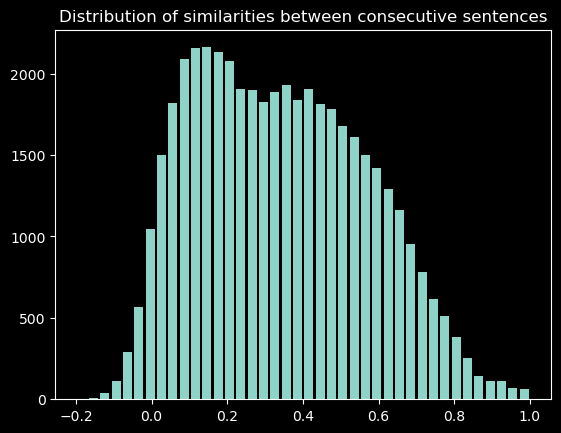

In [11]:
embed_sims = get_cos_sims(par_embeds)
plt.hist(embed_sims, bins=40, rwidth=0.8)
plt.title("Distribution of similarities between consecutive sentences")
plt.show()

In [12]:
sim_mean, sim_std = embed_sims.mean(), embed_sims.std()
groups = []
for art_idx in reduced_pars_df["article_idx"].unique():
    art_par_idxs = reduced_pars_df.index[reduced_pars_df["article_idx"] == art_idx].to_list()
    curr_group = [art_par_idxs[0]]
    for i in range(1, len(art_par_idxs)):
        if embed_sims[i-1] > sim_mean - sim_std:
            curr_group.append(art_par_idxs[i])
        else:
            groups.append(curr_group)
            curr_group = [art_par_idxs[i]]
    if len(curr_group) > 0:
        groups.append(curr_group)

grouped_pars = group_df_by_inds(
    reduced_pars_df.loc[:, ["article_idx","Text"]],
    groups,
    agg_mapping={
        "article_idx": lambda idxs: idxs.mode(),
        "Text": lambda texts: "\n\n".join(texts),
    }
)
grouped_pars

,article_idx,Text
0,0,1. Introduction of Word2vec\n\nWord2vec is one...
1,0,2. Gensim Python Library Introduction\n\nGensi...
2,0,"Or, alternatively for Conda environments:\n\nc..."
3,0,>>> df = pd.read_csv('data.csv')\n>>> df.head()
4,0,3.1 Data Preprocessing:
...,...,...
8861,1390,Many tech companies are able to conduct copiou...
8862,1390,Example: 2014 Facebook Happiness Study
8863,1390,"In 2019, it is no secret that Facebook has our..."
8864,1390,The above excerpt comes from the abstract to t...


In [14]:
code_suspects.to_csv(f"{DATA_DIR}/code_suspects.csv")

reduced_pars_df.to_csv(
    f"{DATA_DIR}/reduced_paragraphs.csv",
    index=False
)

grouped_pars.to_csv(f"{DATA_DIR}/grouped_paragraphs.csv")